In [49]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

import folium
from folium import plugins
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings("ignore")

#한글 데이터를 위한 처리
font_name = font_manager.FontProperties(fname=r"C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

drive_path = r'C:/Users/kyung/Desktop/data_visu/covid_dataset/'

### 연령대별 누적 확진자

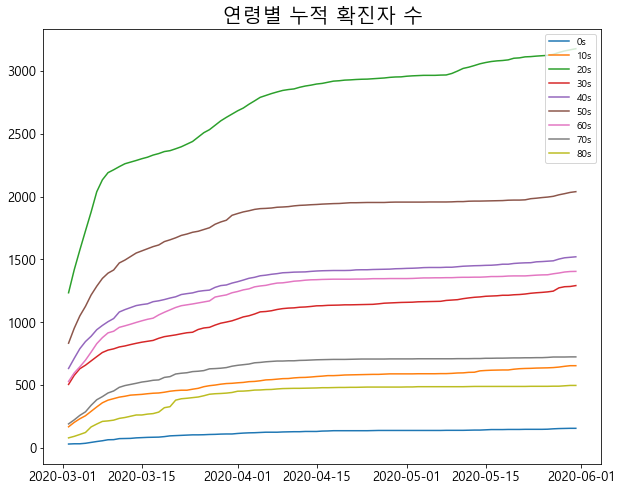

In [15]:
#데이터 로드하기
time_age = pd.read_csv(drive_path + 'TimeAge.csv')

#필요한 컬럼만 남긴 후 확진일과 연령대로 그룹화
time_age = time_age[['date', 'age', 'confirmed']].groupby(['date', 'age']).sum()
time_age = time_age.unstack(level=1)

#확진 날짜 리스트화
date = time_age.index.tolist()
date = pd.to_datetime(date)

#날짜별 확진자 수 리스트화
confirmed = time_age.values.tolist()

# 연령대별로 리스트 나누기
values = {'0s' : [], '10s' : [], '20s': [], '30s' : [], '40s':[], '50s':[], '60s':[], '70s':[], '80s':[] }
for i in range(len(confirmed)):
    values['0s'].append(confirmed[i][0])
    values['10s'].append(confirmed[i][1])
    values['20s'].append(confirmed[i][2])
    values['30s'].append(confirmed[i][3])
    values['40s'].append(confirmed[i][4])
    values['50s'].append(confirmed[i][5])
    values['60s'].append(confirmed[i][6])
    values['70s'].append(confirmed[i][7])
    values['80s'].append(confirmed[i][8])
    
# 연령대별 누적 확진자 그래프 그리기
plt.figure(figsize = (10, 8))
for key in values:
    plt.plot(date, values[key])
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("연령별 누적 확진자 수", fontsize = 20)
plt.legend(values.keys(), loc = 'upper right')
plt.show()

20대 확진자수가 눈에 띄게 높은것을 확인할 수 있다. 

전체 연령대 중에서 유독 왜 20대 확진자 수가 많은 것일까? 
### 가설 1 : 20대의 해외 진출이 많아서 그렇지 않을까? 

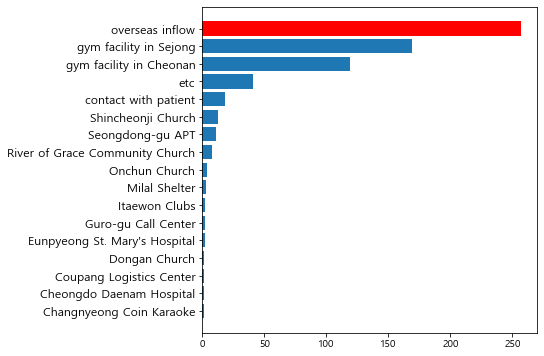

In [161]:
# 데이터 로드 -> 4004 row
patient_info = pd.read_csv(drive_path + 'PatientInfo.csv')

# 결측치 제거 -> 2758 row
patient_info.dropna(axis=0, subset=['infection_case', 'age'], inplace = True)

# infection_case = overseas inflow 만 남기기  -> 610 row
patient_info = patient_info[patient_info.age == '20s']

#감염경로별로 보기
patient_info = patient_info.infection_case
patient_info

#연령별 합 구하고 인덱스로 정렬
counts = patient_info.value_counts().sort_index()
counts = counts.sort_values()
values = np.array(counts)

#인덱스 라벨링
labels = patient_info.value_counts().sort_index().index
labels = np.array(labels)

# 그래프 그리기 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111) # = add_subplot(1,1,1) (row, column, position)

xpos = np.arange(len(values)) # range(len(countries))
plt.barh(xpos, values, height=0.8) # , align='center'
# plt.yticks(fontsize=20)
# plt.ylabel('확진', fontsize=30)
plt.yticks(xpos, labels, fontsize = 12)
# plt.xlabel('감염 경로', fontsize=15)
plt.barh(xpos[-1], values[-1], color='r')
plt.show()

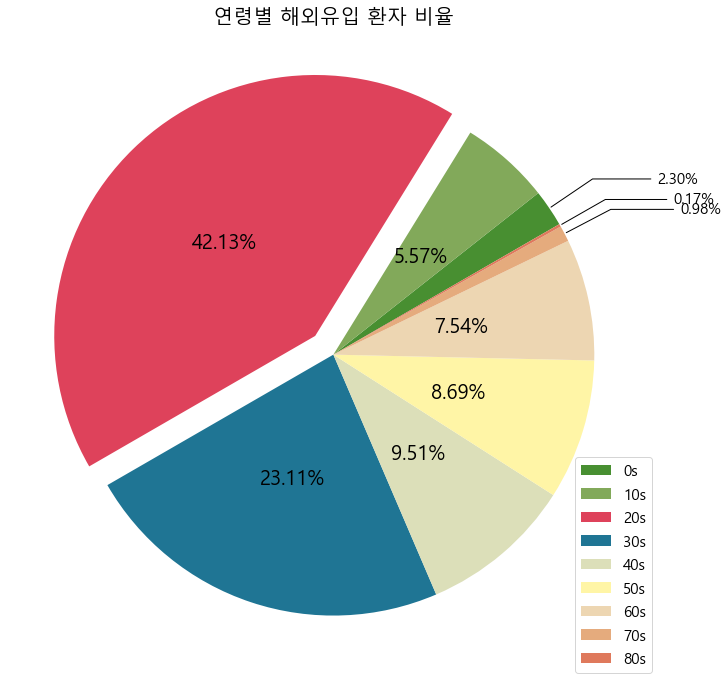

In [162]:

# 데이터 로드 -> 4004 row
patient_info = pd.read_csv(drive_path + 'PatientInfo.csv')

# 결측치 제거 -> 2758 row
patient_info.dropna(axis=0, subset=['infection_case', 'age'], inplace = True)

# infection_case = overseas inflow 만 남기기  -> 610 row
patient_info = patient_info[patient_info.infection_case == 'overseas inflow']

#연령별로 나누기
patient_age = patient_info.age

#연령별 합 구하고 인덱스로 정렬
counts = patient_age.value_counts().sort_index()
values = np.array(counts)

#인덱스 라벨링
labels = patient_age.value_counts().sort_index().index
labels = np.array(labels)

# 20대 떼어내기
explodes = [0, 0, 0.1, 0, 0, 0, 0, 0, 0]

#파이차트 색 -> 좀더 구분 잘 되는 색으로 바꿔야한다. 
colors = ['#488f31','#82a95a','#de425b','#1f7594','#dcdfb9','#fff5a6','#edd6b2','#e5ab7d','#df795c']

# pie chart 
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot() ## 프레임 생성
plt.pie(values, explode = explodes,
        colors = colors, startangle = 30)

total = np.sum(values)

threshold = 5
sum_pct = 0

bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일

## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-'),bbox=bbox_props,va='center')
 
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(labels) - 1:
        sum_pct += float(f'{values[i]/total*100:.2f}')
        text = f'{values[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 계단형태로 만든다.
    if values[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x, 1.2*y),
                    horizontalalignment=horizontalalignment,fontsize=15, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=20)
    

plt.legend(labels, fontsize = 15, loc = 'lower right')
plt.title('연령별 해외유입 환자 비율', fontsize = 20)
plt.show()

실제로 전 연령별 해외유입 환자의 비율은 20대의 수가 약 42%로 높은 비율을 차지한 것을 알 수 있다.

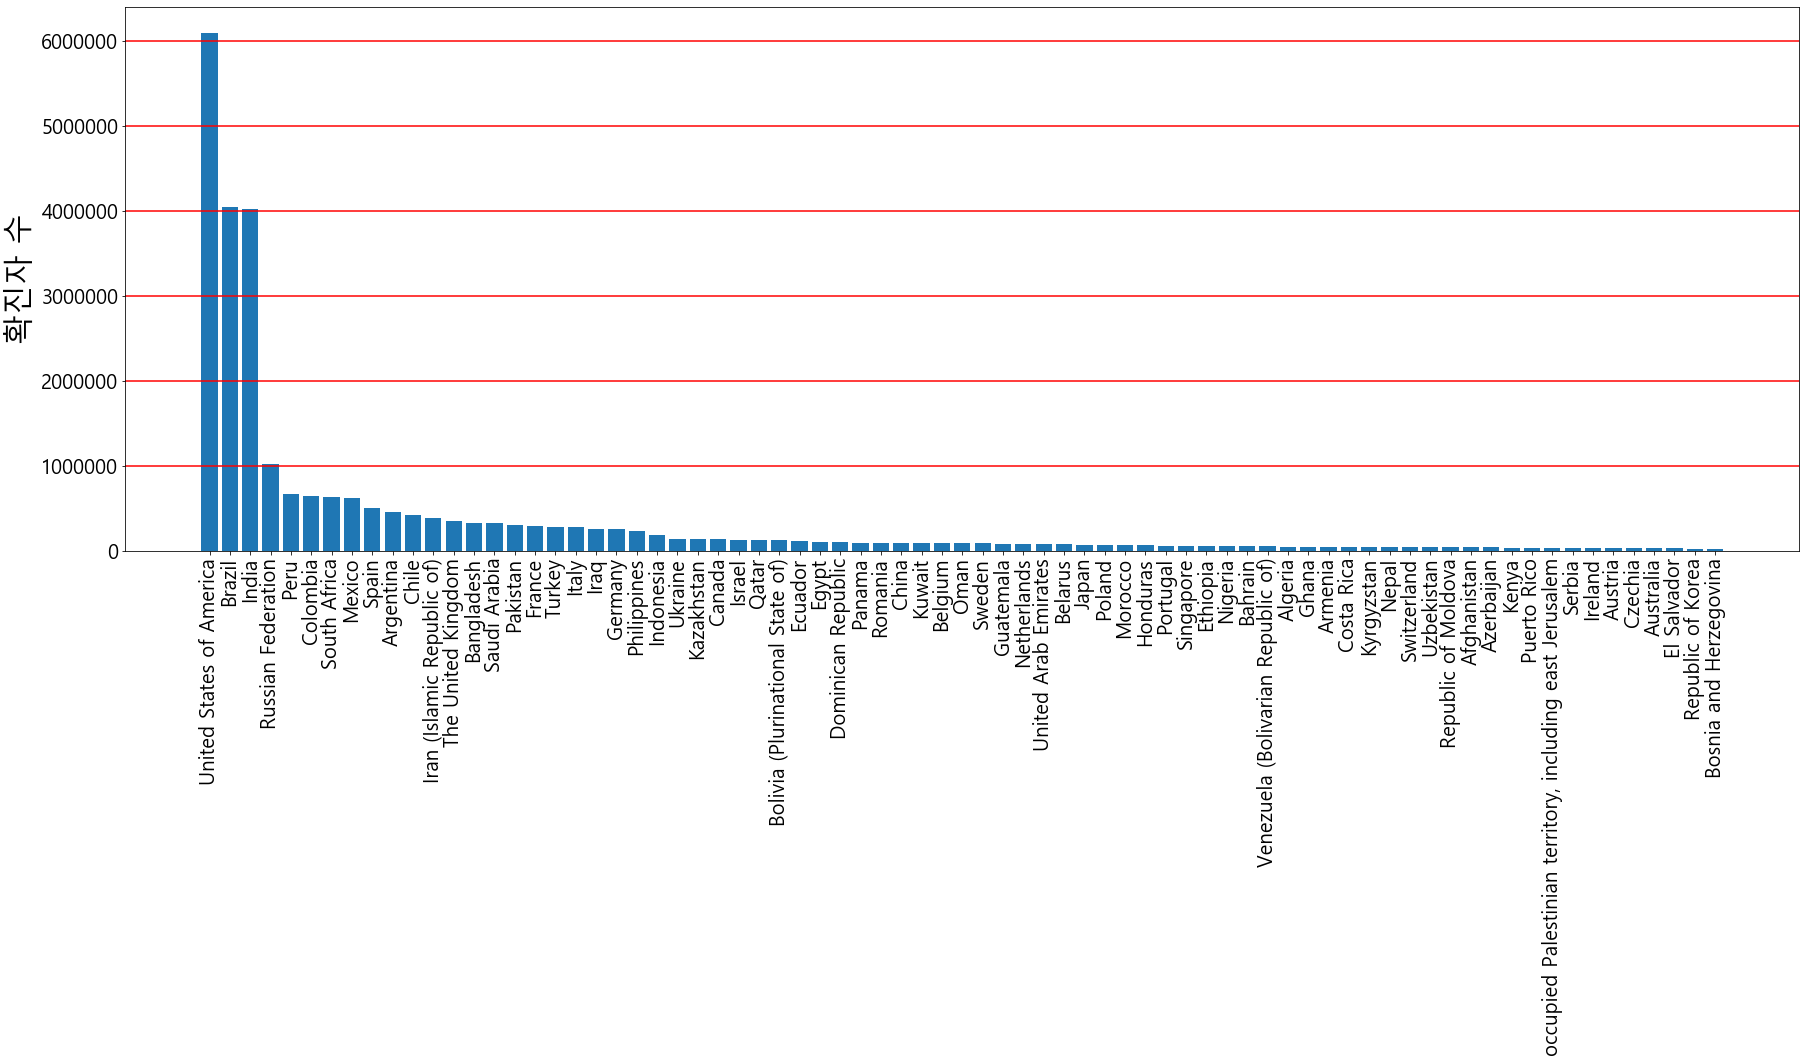

In [186]:
# 출처 WHO Novel Coronavirus (2019-nCoV) situation reports : https://covid19.who.int/
global_covid = pd.read_csv(drive_path+'WHO-COVID-19-global-data.csv')

# csv 컬럼에 포함된 공백 제거
global_covid.columns = global_covid.columns.str.strip()

#필요한 컬럼만 남기기
global_covid = global_covid[['Date_reported', 'Country_code', 'Country', 'WHO_region', 'New_cases']]

# Country 별로 그룹화
# country = global_covid.groupby('Country').sum()
country = global_covid.groupby(['Country_code','Country']).sum()

# 국가별 누적확진자 -> 총 216개국
# country_count = country.sort_values(by="New_cases") #, ascending=False  #DataFrame
country_count = country.New_cases.sort_values(ascending=False) #Series

# 그래프 표시값 전처리
countries = country_count.index.tolist()[:75] # i 총 216개국 중 상위 100개국만 추리기
countries = dict(countries)
values = country_count.values.tolist()[:75]  #f

# 그래프 그리기 
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111) # = add_subplot(1,1,1) (row, column, position)
v_line = [1000000, 2000000, 3000000,4000000,5000000,6000000]

xpos = np.arange(len(countries)) # range(len(countries))
plt.bar(xpos, values, width=0.8) # , align='center'
plt.yticks(fontsize=20)
plt.ylabel('확진자 수', fontsize=30)
plt.xticks(xpos, countries.values(),rotation=90, fontsize = 20)
# plt.xlabel('국가', fontsize=30)
for line in v_line:
    ax.axhline(line, color = 'r')
plt.show()

In [180]:
country.sort_values(by='New_cases', ascending = False, inplace = True)
country = country[:75]
country

,,New_cases
Country_code,Country,
US,United States of America,6095007
BR,Brazil,4041638
IN,India,4023179
RU,Russian Federation,1020310
PE,Peru,670145
...,...,...
CZ,Czechia,27249
AU,Australia,26136
SV,El Salvador,26099


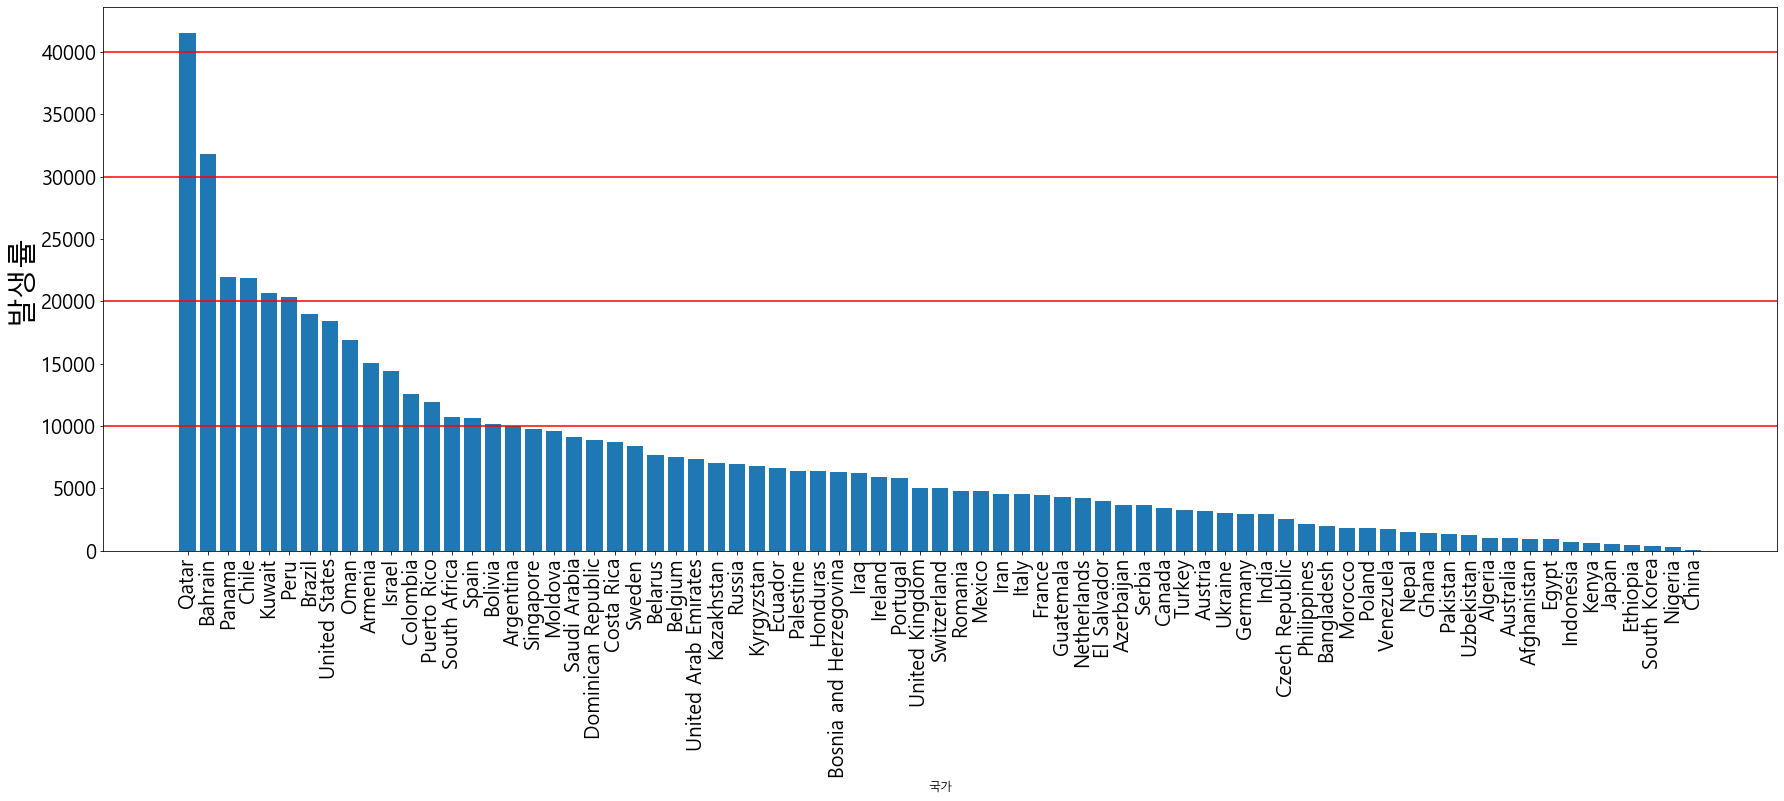

In [181]:
# 인구수 데이터 로드
popu = pd.read_csv(drive_path + 'population_Data.csv')

# 컬럼명 바꾸기
popu.rename(columns={'cca2':'Country_code'}, inplace = True)

# 필요한 컬럼만 남기기
popu = popu[['Country_code','name', 'pop2020']]

#인구수 단위 변경
for i in range(len(popu)):
    popu['pop2020'][i] = popu['pop2020'][i]*1000

#인구수 type변경
popu.pop2020 = popu.pop2020.astype(int)
popu = popu[['Country_code','name', 'pop2020']]

# 데이터 병합
df_merge = pd.merge(country, popu, on = 'Country_code')

data = np.array(df_merge)

inci_list = []
for i in range(len(data)):
    x = data[i][1]
    y = data[i][3]
    incidence = (x/y)*1000000
    inci_list.append([data[i][2],int(format(incidence, ".0f"))])

df = pd.DataFrame(inci_list)
df.columns = ['Country', 'Incidence']
df.sort_values(['Incidence'], ascending=False,inplace = True)
df = df[:160]

countries = df['Country'].values #국가
values = df['Incidence'].values #발생률

# 그래프 그리기 
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(111) # = add_subplot(1,1,1) (row, column, position)
v_line = [10000,20000,30000,40000]

xpos = np.arange(len(df)) # range(len(countries))
plt.bar(xpos, values, width=0.8) # , align='center'
plt.yticks(fontsize=20)
plt.ylabel('발생률', fontsize=30)
plt.xticks(xpos, countries,rotation=90, fontsize = 20)
plt.xlabel('국가', fontsize=12)
for line in v_line:
    ax.axhline(line, color = 'r')
plt.show()

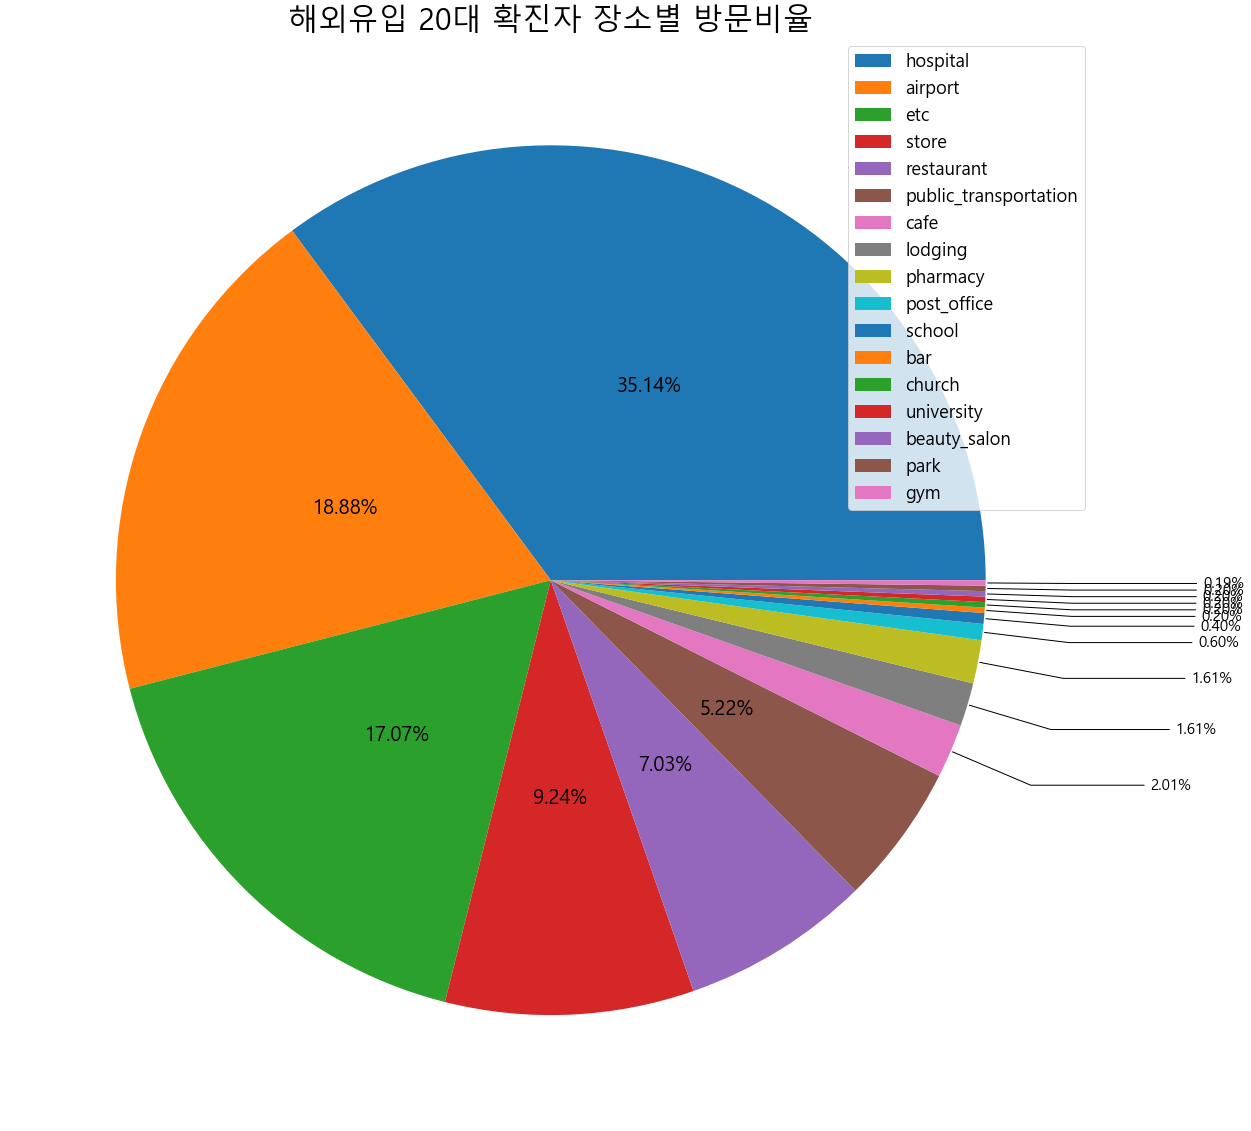

In [123]:
# infection_case = overseas inflow & age = 20s만 남기기  -> 257 row
patient_info = patient_info[(patient_info.infection_case == 'overseas inflow') & (patient_info.age == '20s')]
patient_info 

# Patient Route 데이터 로드
patient_route = pd.read_csv(drive_path + 'PatientRoute.csv')

#20대 환자의 동선을 알기 위해 Patient Route와 Patient Info merge
twenties = pd.merge(patient_info, patient_route, on='patient_id')
# twenties.sort_values(by='patient_id').head(10)

# 최다 방문 장소 
place_data = twenties.type.value_counts()

#장소명
place_name = place_data.index

# pie chart 
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot() ## 프레임 생성
plt.pie(place_data)

total = np.sum(place_data)

threshold = 5
sum_pct = 0

bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일

## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-'),bbox=bbox_props,va='center')

 
for i,l in enumerate(place_data):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    
    if i < len(place_data) - 1:
        sum_pct += float(f'{place_data[i]/total*100:.2f}')
        text = f'{place_data[i]/total*100:.2f}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    
    ## 비율 상한선보다 작은 것들은 계단형태로 만든다.
    if place_data[i]/total*100 < threshold:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x, 1.2*y),
                    horizontalalignment=horizontalalignment,fontsize=15, **config)
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=20)
    

plt.legend(place_name, fontsize = 18, loc = 'upper right')
plt.title('해외유입 20대 확진자 장소별 방문비율', fontsize = 30)
plt.show()

In [124]:
# 20대 해외 유입 확진자의 전국 분포 확인
patient_province = patient_info.province.value_counts()

# 분포를 알아보기 위한 위도 경도
location = twenties[['latitude', 'longitude']]

In [125]:
# 히트맵
center = [36.4, 128]
m = folium.Map(
    location = center,
    zoom_start = 6.5, 
    titles = 'test'
)
HeatMap(location[1:]).add_to(m)
m

In [126]:
center = [36.4, 128]
m3 = folium.Map(location=center, zoom_start = 7)
plugins.MousePosition().add_to(m3)
plugins.MarkerCluster(location).add_to(m3)
m3

#### 대부분의 20대 해외 유입 확진자의 동선은 병원을 가장 많이 방문
결론 : 20대 해외유입 확진자들의 주요 방문지인 병원과 공항을 중심으로 철저한 방역이 필요하다.
특히 수도권 지역과 부산에서 주의가 필요하다.